먼저 Feature들을 하나씩 만든다.
그리고 xgboost를 강의 내용을 따라하면서 튜닝해서 만들어본다.

https://github.com/KaggleBreak/walkingkaggle/blob/master/rental_listing/rental_listing_0422.ipynb

## Features & Issues

list all features
  * Numerical data
    * price
    * price_per_bedrooms: price / bedrooms
    * bathrooms
    * bedrooms
    * room_sum: bedrooms + bathrooms
    * num_priceXroom: price / (1 + bedrooms + 0.5*bathrooms) -> https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths 참고했다고 한다. 
    * latitude
    * longitude
    * dist_from_center: sqrt((latitude-latitude.median())**2 + (longitude - longitude.median()) & apply precision 
    * num_photos: apply len to photos list
    * num_features: apply len to features list
    * num_description_words: apply split(" ") to description
    * building_avg_score
    * building_frequency
    * manager_avg_score
    * manager_frequency
    * created: Neural Network 파트에서 weekday, weekofyear로 변환해서 사용. **시간도 의미가 있었는데** 이걸 사용할 필요성 있을듯?
  * Categorical data
    * display_address
   
    
raw data but not used for feature
  * listing_id -> 이건 created 별로 scaling을 해서 쓰는게 맞다고 보는데. categorical로 할 필요가 없을 듯.
  * manager_id, building_id는 각각 평균 score와 빈도로 numerical data로 바꿨는데 또 추가할 필요가 있을까?
  * steet_address는 할 필요 없고 display_address로만 하는것이 좋을 듯. 동네만 알면 되지 번지까지 할 필욘 없으니깐.

Features related issues
  * interest_level의 대부분이 low이고 high가 적기 때문에 클래스간 비율을 위해 oversampling / undersampling이 필요할 듯
  * interest_level의 Numerical incoding이 필요할까? -> low, medium, high이기 때문에 0, 1, 2를 적용하는 것은 합리적이긴 함.
  * tfidf 팩터화..가 뭘까? 뭔가 stop words를 제외시키는 작업인 듯 한데.
  * outlier들: price, bedrooms, bathrooms, longitude, latitude 처리 필요성 -> pandas의 clip을 사용하면 아웃라이어들을 특정한 값으로 지정 가능.
  * dist_from_center의 precision을 적용, 일정구역을 같은 값으로 설정한 후에 density도 구하던데, 이게 feature로 유용할지 잘 모르겠어서 일단 제외.
  * Neural Network 파트에서 building_id와 manager_id에 대해 supervised를 계산하는데 이게 뭔지 잘 모르겠음. frequency는 알것는데. 이거 확인해보고 feature에 넣어주는 걸 고려
  * Neural Network 파트에서 price를 digitize를 한다. 뭐하는건지 확인.
  * Neural Network 파트에서 0.5 단위 bathrooms를 num_even_bathrooms로 처리를 해주는데 어떻게 넣어줬는지 잘 모르겠음.
  * Neural Network 파트에서 특정 단어들에 대해서 몇번 나왔는지 체크하는 것도 feature로 사용한듯 보인다. 

XGBoost related issues
  * change data to fit on XGB
  * XGB는 아웃라이어에 대해 영향을 덜 받을까?

sklearn에서는 DataFrameMapper로 StandardScaler를 사용할 수 있는 듯. -> 이거 볼 필요성은 있겠다. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
train = pd.read_json('./data/train.json')
test = pd.read_json('./data/test.json')

In [4]:
train.tail()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
9999,1.0,2,297160caf8a88c10718b492d4672c6b4,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,"[Elevator, Laundry in Building, Laundry in Uni...",medium,40.7426,7098690,-73.9790,2a1ee03b449700c3a15dd8c9a505c525,[https://photos.renthop.com/2/7098690_18396d32...,3200,230 E 30 St
99991,1.0,1,9e871ccfea7b07686c101548ca693af6,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",low,40.7102,6822449,-74.0163,ef20d40b528500037e37b167787ac089,[https://photos.renthop.com/2/6822449_b429587b...,3950,225 Rector Place
99992,1.0,1,7967a1280bf3f7644500fc79d2696b0e,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",low,40.7601,6881461,-73.9900,d889a9552265fe359e7d36d172084fcb,[https://photos.renthop.com/2/6881461_20a86530...,2595,341 West 45th Street
99993,1.0,0,ad67f6181a49bde19218929b401b31b7,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",low,40.7066,6841891,-74.0101,9fd3af5b2d23951e028059e8940a55d7,[https://photos.renthop.com/2/6841891_124c9c44...,3350,37 Wall Street
99994,1.0,2,5173052db6efc0caaa4d817112a70f32,2016-04-12 02:48:07,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,[Hardwood Floors],low,40.8699,6858245,-73.9172,d7f57128272bfd82e33a61999b5f4c42,[https://photos.renthop.com/2/6858245_c4380bde...,2200,30 Park Terrace East


### Numerical Features

* price
* price_per_bedrooms: price / bedrooms
* bathrooms
* bedrooms
* room_sum: bedrooms + bathrooms
* num_priceXroom: price / (1 + bedrooms + 0.5*bathrooms) -> https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths 참고했다고 한다. 
* latitude
* longitude
* dist_from_center: sqrt((latitude-latitude.median())**2 + (longitude - longitude.median()) & apply precision 
* num_photos: apply len to photos list
* num_features: apply len to features list
* num_description_words: apply split(" ") to description
* building_avg_score
* building_frequency
* manager_avg_score
* manager_frequency
* created: Neural Network 파트에서 weekday, weekofyear로 변환해서 사용.

In [10]:
# numerical encoding of target value
train.loc[:, 'interest_level_in_num'] = 0.0
train.loc[train.loc[:, 'interest_level'] == 'medium', 'interest_level_in_num'] = 1.0
train.loc[train.loc[:, 'interest_level'] == 'high', 'interest_level_in_num'] = 2.0

# making derivated features for train data
train.loc[:, 'price_per_bedrooms'] = train.loc[:, 'price'] / train.loc[:, 'bedrooms']
train.loc[:, 'price_per_bathrooms'] = train.loc[:, 'price'] / train.loc[:, 'bathrooms']
# https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths
train.loc[:, 'priceXroom'] = (train.loc[:, 'price'] / (1. + train.loc[:, 'bedrooms'].clip(1, 4) + \
                                                       0.5*train.loc[:, 'bathrooms'].clip(0, 2)))
train.loc[:, 'room_diff'] = train.loc[:, 'bedrooms'] - train.loc[:, 'bathrooms']
train.loc[:, 'room_sum'] = train.loc[:, 'bedrooms'] + train.loc[:, 'bathrooms']
train.loc[:, 'dist_from_center'] = np.sqrt((train.loc[:, 'latitude'] - train.loc[:, 'latitude'].median())**2 + \
                                           (train.loc[:, 'longitude'] - train.loc[:, 'longitude'].median())**2)
train.loc[:, 'num_photos'] = train.loc[:, 'photos'].apply(len)
train.loc[:, 'num_features'] = train.loc[:, 'features'].apply(len)
# maybe better to exclude 'stop words' by using tfid??
train.loc[:, 'num_description_words'] = train.loc[:, 'description'].apply(lambda x: len(x.split(" ")))

# apply scores depends on building id and manager id
b_id_freq_th = 15. # frequency threshold for assigning building id interest level in num score
m_id_freq_th = 15. # frequency threshold for assigning manager id interest level in num score

grouped = train.groupby('building_id')['interest_level_in_num'].aggregate(['count', 'mean'])
tmp_dic = grouped.loc[grouped.loc[:, 'count'] > b_id_freq_th, 'mean'].to_dict()
tmp_avg = train.loc[:, 'interest_level_in_num'].mean()
train.loc[:, 'building_avg_score'] = train.loc[:, 'building_id'].apply(lambda x: tmp_dic.get(x, tmp_avg))
test.loc[:, 'building_avg_score'] = test.loc[:, 'building_id'].apply(lambda x: tmp_dic.get(x, tmp_avg)) # using train data

tmp_dic = train.loc[:, 'building_id'].value_counts().to_dict()
tmp_avg = train.loc[:, 'building_id'].value_counts().min()
train.loc[:, 'building_frequency'] = train.loc[:, 'building_id'].apply(lambda x: tmp_dic.get(x, tmp_avg))
test.loc[:, 'building_frequency'] = test.loc[:, 'building_id'].apply(lambda x: tmp_dic.get(x, tmp_avg)) # using train data

train.loc[:, 'zero_bldg'] = (train.loc[:, 'building_id'] != '0') * 1.0
test.loc[:, 'zero_bldg'] = (test.loc[:, 'building_id'] != '0') * 1.0

grouped = train.groupby('manager_id')['interest_level_in_num'].aggregate(['count', 'mean'])
tmp_dic = grouped.loc[grouped.loc[:, 'count'] > m_id_freq_th, 'mean'].to_dict()
tmp_avg = train.loc[:, 'interest_level_in_num'].mean()
train.loc[:, 'manager_avg_score'] = train.loc[:, 'manager_id'].apply(lambda x: tmp_dic.get(x, tmp_avg))
test.loc[:, 'manager_avg_score'] = test.loc[:, 'manager_id'].apply(lambda x: tmp_dic.get(x, tmp_avg)) # using train data

tmp_dic = train.loc[:, 'manager_id'].value_counts().to_dict()
tmp_avg = train.loc[:, 'manager_id'].value_counts().min()
train.loc[:, 'manager_frequency'] = train.loc[:, 'manager_id'].apply(lambda x: tmp_dic.get(x, tmp_avg))
test.loc[:, 'manager_frequency'] = test.loc[:, 'manager_id'].apply(lambda x: tmp_dic.get(x, tmp_avg)) # using train data

# created
train.loc[:, 'created'] = pd.to_datetime(train.loc[:, 'created'])
train.loc[:, 'dayofweek'] = train.loc[:, 'created'].dt.dayofweek
train.loc[:, 'weekofyear'] = train.loc[:, 'created'].dt.weekofyear
train.loc[:, 'dayofyear'] = train.loc[:, 'created'].dt.dayofyear
train.loc[:, 'month'] = train.loc[:, 'created'].dt.month
train.loc[:, 'day'] = train.loc[:, 'created'].dt.day
train.loc[:, 'hour'] = train.loc[:, 'created'].dt.hour

In [11]:
# making derivated features for test data
test.loc[:, 'price_per_bedrooms'] = test.loc[:, 'price'] / test.loc[:, 'bedrooms']
test.loc[:, 'price_per_bathrooms'] = test.loc[:, 'price'] / test.loc[:, 'bathrooms']
# https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths
test.loc[:, 'priceXroom'] = (test.loc[:, 'price'] / (1. + test.loc[:, 'bedrooms'].clip(1, 4) + \
                                                       0.5*test.loc[:, 'bathrooms'].clip(0, 2)))
test.loc[:, 'room_diff'] = test.loc[:, 'bedrooms'] - test.loc[:, 'bathrooms']
test.loc[:, 'room_sum'] = test.loc[:, 'bedrooms'] + test.loc[:, 'bathrooms']
test.loc[:, 'dist_from_center'] = np.sqrt((test.loc[:, 'latitude'] - test.loc[:, 'latitude'].median())**2 + \
                                           (test.loc[:, 'longitude'] - test.loc[:, 'longitude'].median())**2)
test.loc[:, 'num_photos'] = test.loc[:, 'photos'].apply(len)
test.loc[:, 'num_features'] = test.loc[:, 'features'].apply(len)
# maybe better to exclude 'stop words' by using tfid??
test.loc[:, 'num_description_words'] = test.loc[:, 'description'].apply(lambda x: len(x.split(" ")))

# created
test.loc[:, 'created'] = pd.to_datetime(test.loc[:, 'created'])
test.loc[:, 'dayofweek'] = test.loc[:, 'created'].dt.dayofweek
test.loc[:, 'weekofyear'] = test.loc[:, 'created'].dt.weekofyear
test.loc[:, 'dayofyear'] = test.loc[:, 'created'].dt.dayofyear
test.loc[:, 'month'] = test.loc[:, 'created'].dt.month
test.loc[:, 'day'] = test.loc[:, 'created'].dt.day
test.loc[:, 'hour'] = test.loc[:, 'created'].dt.hour

### Categorical Features

* display_address

제외
* listing_id -> 이건 created 별로 scaling을 해서 쓰는게 맞다고 보는데. categorical로 할 필요가 없을 듯.
* manager_id, building_id는 각각 평균 score와 빈도로 numerical data로 바꿨는데 또 추가할 필요가 있을까?
* steet_address는 할 필요 없고 display_address로만 하는것이 좋을 듯. 동네만 알면 되지 번지까지 할 필욘 없으니깐.

Issues
* 근데 encoding을 LabelEncoder로 하는게 맞나? OneHotEncoder로 해야 맞는거 아닌가?

In [12]:
from sklearn import preprocessing

In [13]:
le = preprocessing.LabelEncoder()
le.fit(np.append(train.loc[:, 'display_address'].values, test.loc[:, 'display_address'].values))
train.loc[:, 'le_display_address'] = le.transform(train.loc[:, 'display_address'].values)
test.loc[:, 'le_display_address'] = le.transform(test.loc[:, 'display_address'].values)

In [14]:
train.loc[:, 'le_display_address'].tail()

9999      9577
99991    12864
99992    15306
99993    14850
99994    12707
Name: le_display_address, dtype: int64

### Adding more features

Little Boat https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32123 posting suggest "encoding other categorical features" to some "important" features (especially manager_id)

https://github.com/plantsgo/Rental-Listing-Inquiries

In [15]:
def get_stats(train_df, test_df, target_cols, group_col, agg_func=['count', 'mean', 'std', 'median', 'max', 'min']):
    all_df = train_df.append(test_df)
    ret_df = all_df.groupby(group_col)[target_cols].aggregate(agg_func)
    ret_df.columns = [group_col+'_'+'_'.join(col) for col in ret_df.columns.values]
    return ret_df

In [16]:
manager_id_target_cols = ['price', 'price_per_bedrooms', 'price_per_bathrooms', 'priceXroom', 'bathrooms', 'bedrooms', 'room_sum', \
                          'latitude', 'longitude', 'num_photos', 'num_features', 'num_description_words', 'building_avg_score', \
                          'building_frequency', 'dayofweek', 'weekofyear', 'hour', 'dayofyear', 'month', 'day', 'room_diff', \
                          'zero_bldg']
stats_df = get_stats(train, test, manager_id_target_cols, 'manager_id')
train = train.merge(stats_df, how='left', left_on='manager_id', right_index=True)
test = test.merge(stats_df, how='left', left_on='manager_id', right_index=True)

In [17]:
bedrooms_target_cols = ['price', 'listing_id', 'dayofweek', 'weekofyear', 'dayofyear', 'month', 'day', 'hour', \
                       'num_features', 'building_frequency']
stats_df = get_stats(train, test, bedrooms_target_cols, 'bedrooms')
train = train.merge(stats_df, how='left', left_on='bedrooms', right_index=True)
test = test.merge(stats_df, how='left', left_on='bedrooms', right_index=True)

With 'manager_id', Little Boat said bedrooms stats features also contribute to his best model. However, fundamentally, it is harder to understand how bedrooms stats help to imporove the model compare to manager_id. Let's just test manager_id stats features first.

In [18]:
features_to_use = ['price', 'price_per_bedrooms', 'price_per_bathrooms', 'priceXroom', 'bathrooms', 'bedrooms', 'room_sum', 'latitude', \
                   'longitude', 'num_photos', 'num_features', 'num_description_words', 'building_avg_score', \
                   'building_frequency', 'manager_avg_score', 'manager_frequency', 'dayofweek', 'weekofyear', 'hour', \
                   'le_display_address', 'dayofyear', 'day', 'room_diff', 'zero_bldg']

In [19]:
manager_id_features = train.columns[-17*6:].values
bedrooms_features = train.columns[-11*6:].values

In [20]:
all_features_to_use = np.append(features_to_use,manager_id_features)
all_features_to_use = np.append(all_features_to_use, bedrooms_features)

In [21]:
print len(features_to_use), len(manager_id_features), len(bedrooms_features), len(all_features_to_use)

24 102 66 192


## xgb part

### data transform for xgb

In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [23]:
# https://datascience.stackexchange.com/questions/12799/pandas-dataframe-to-dmatrix
xgtrain = xgb.DMatrix(train.loc[:, features_to_use].values, label=train.loc[:, 'interest_level_in_num'].values)

### Running xgb

In [24]:
from sklearn.model_selection import StratifiedKFold

In [25]:
# for xgb.train
params = {
    'objective':'multi:softprob',
    'max_depth':5,
    'silent':1,
    'eta':0.03,
    'num_class':3,
    'eval_metric':'mlogloss'
}

num_rounds = 100

In [26]:
X = train.loc[:, all_features_to_use].values
y = train.loc[:, 'interest_level_in_num'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

In [27]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
    bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-mlogloss:1.07815	train-mlogloss:1.078
[1]	test-mlogloss:1.05867	train-mlogloss:1.05836
[2]	test-mlogloss:1.04016	train-mlogloss:1.03971
[3]	test-mlogloss:1.02257	train-mlogloss:1.02198
[4]	test-mlogloss:1.00583	train-mlogloss:1.00506
[5]	test-mlogloss:0.989934	train-mlogloss:0.988979
[6]	test-mlogloss:0.974696	train-mlogloss:0.973589
[7]	test-mlogloss:0.960179	train-mlogloss:0.9589
[8]	test-mlogloss:0.946315	train-mlogloss:0.94487
[9]	test-mlogloss:0.93305	train-mlogloss:0.931438
[10]	test-mlogloss:0.920343	train-mlogloss:0.918597
[11]	test-mlogloss:0.908195	train-mlogloss:0.906283
[12]	test-mlogloss:0.896495	train-mlogloss:0.894458
[13]	test-mlogloss:0.885349	train-mlogloss:0.883163
[14]	test-mlogloss:0.874647	train-mlogloss:0.872317
[15]	test-mlogloss:0.864374	train-mlogloss:0.861901
[16]	test-mlogloss:0.854535	train-mlogloss:0.851921
[17]	test-mlogloss:0.845105	train-mlogloss:0.842326
[18]	test-mlogloss:0.836042	train-mlogloss:0.833097
[19]	test-mlogloss:0.827343	train-mlog

In [28]:
all_features_to_use[8]

'longitude'

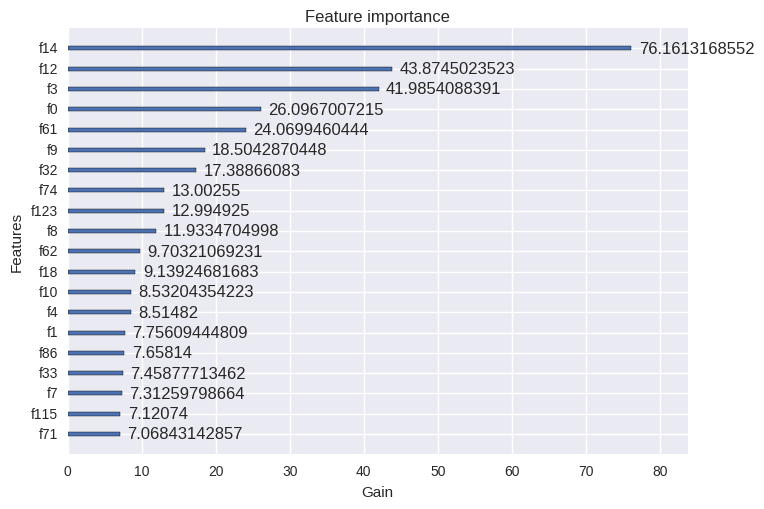

In [29]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain', max_num_features=20)

in 1st place winnder's https://github.com/plantsgo/Rental-Listing-Inquiries/blob/master/xgb.py 

    params = {'booster': 'gbtree',
              #'objective': 'multi:softmax',
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'gamma': 1,
              'min_child_weight': 1.5,
              'max_depth': 5,
              'lambda': 10,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'eta': 0.03,
              'tree_method': 'exact',
              'seed': 2017,
              'nthread': 12,
              "num_class":3
              }
    num_round = 10000
    early_stopping_rounds = 50
    
    watchlist = [(train_matrix, 'train'),
                 (test_matrix, 'eval')
                 ]
    if test_matrix:
        model = xgb.train(params, train_matrix, num_boost_round=num_round, evals=watchlist,
                      early_stopping_rounds=early_stopping_rounds
                      )
        pred_test_y = model.predict(test_matrix,ntree_limit=model.best_iteration)
        return pred_test_y, model
    else:
        model = xgb.train(params, train_matrix, num_boost_round=num_round
                      )
        return model

In [36]:
# for xgb.train
params = {
    'objective':'multi:softprob',
    'max_depth':5,
    'silent':1,
    'eta':0.03,
    'num_class':3,
    'eval_metric':'mlogloss', 
    'subsample': 0.7,
    'colsample_bytree': 0.7, 
    'colsample_bylevel': 0.7, 
    'tree_method': 'exact', 
    'min_child_weight': 1.5, 
    'lambda': 10, 
    'gamma': 1
}

num_rounds = 2000
early_stopping_rounds = 20

In [37]:
X = train.loc[:, all_features_to_use].values
y = train.loc[:, 'interest_level_in_num'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)

In [154]:
for train_index, test_index in skf.split(X, y):
    print train_index

[    2     3     4 ..., 49349 49350 49351]
[    0     1     2 ..., 49348 49350 49351]
[    0     1     4 ..., 49349 49350 49351]
[    0     1     2 ..., 49348 49349 49350]
[    0     1     2 ..., 49346 49349 49351]


In [155]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
    bst = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=watchlist)

[0]	test-mlogloss:1.07785	train-mlogloss:1.0776
[1]	test-mlogloss:1.05862	train-mlogloss:1.05806
[2]	test-mlogloss:1.04121	train-mlogloss:1.04034
[3]	test-mlogloss:1.02371	train-mlogloss:1.02255
[4]	test-mlogloss:1.00713	train-mlogloss:1.00561
[5]	test-mlogloss:0.991354	train-mlogloss:0.989449
[6]	test-mlogloss:0.975869	train-mlogloss:0.97366
[7]	test-mlogloss:0.961122	train-mlogloss:0.958569
[8]	test-mlogloss:0.947583	train-mlogloss:0.944734
[9]	test-mlogloss:0.93418	train-mlogloss:0.931056
[10]	test-mlogloss:0.921935	train-mlogloss:0.918534
[11]	test-mlogloss:0.909453	train-mlogloss:0.905747
[12]	test-mlogloss:0.898042	train-mlogloss:0.894006
[13]	test-mlogloss:0.886982	train-mlogloss:0.88263
[14]	test-mlogloss:0.875903	train-mlogloss:0.871184
[15]	test-mlogloss:0.865351	train-mlogloss:0.860313
[16]	test-mlogloss:0.855685	train-mlogloss:0.850326
[17]	test-mlogloss:0.846435	train-mlogloss:0.840799
[18]	test-mlogloss:0.83712	train-mlogloss:0.831219
[19]	test-mlogloss:0.828395	train-mlo

With just 'features_to_use', the best score is "[2662]	test-mlogloss:0.538867	train-mlogloss:0.335969"

with just 'manager_id_features', the best score is "[990]	test-mlogloss:0.659298	train-mlogloss:0.58707"

In [39]:
X.shape

(49352, 192)

In [38]:
# making submmit file
dtest = xgb.DMatrix(test.loc[:, all_features_to_use].values)
dtrain = xgb.DMatrix(X, y)

model = xgb.train(params, dtrain, num_boost_round=num_rounds)

In [40]:
pred_test = model.predict(dtest)

In [41]:
out_df = pd.DataFrame(pred_test)
out_df.columns = ['low', 'medium', 'high']
out_df.loc[:, 'listing_id'] = test.loc[:, 'listing_id'].values
out_df.loc[:, ['listing_id', 'high', 'medium', 'low']].to_csv('./data/xgb_all_features.csv', index=False)

In [59]:
pred_test

array([[ 0.40748122,  0.44685197,  0.14566681],
       [ 0.96654153,  0.01125877,  0.02219969],
       [ 0.83025759,  0.15360817,  0.01613423],
       ..., 
       [ 0.49655908,  0.38804275,  0.1153982 ],
       [ 0.27064472,  0.45110559,  0.27824971],
       [ 0.79035372,  0.17333017,  0.03631615]], dtype=float32)

### Bias-Variance Trade off

In [18]:
from sklearn.model_selection import validation_curve

- use Scikit-learn wrapper,
- train the model for different values of trees (`n_estimators`) using stratified 10-fold CV,
- plot train/test errors

In [22]:
# for XGBClassifier
default_params = {
    'objective': 'multi:softprob',
    'max_depth': 2,
    'learning_rate': 0.5,
    'silent': 1.0
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2017)
n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=skf,
    scoring='neg_log_loss'
)

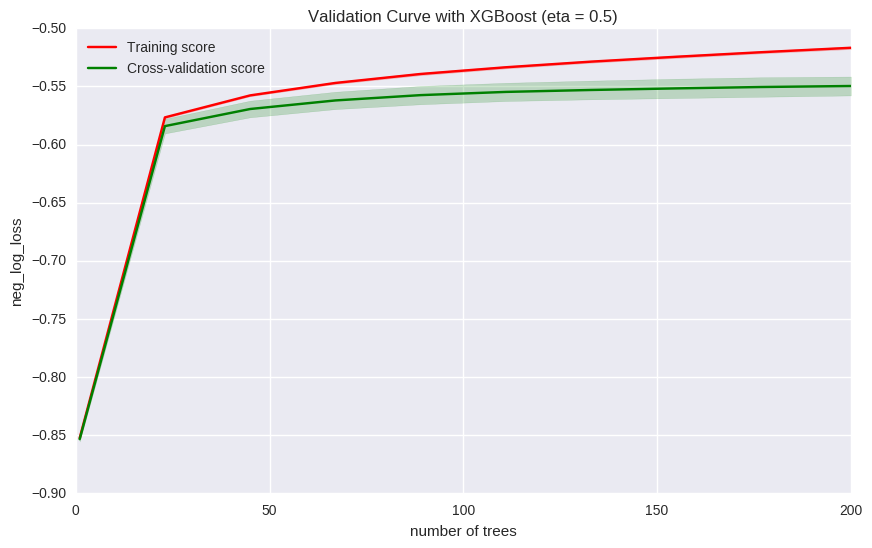

Best cross-validation result (-0.55) obtained for 200 trees


In [23]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.5)")
plt.xlabel("number of trees")
plt.ylabel("neg_log_loss")

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

In [43]:
# for XGBClassifier - 파라미터 몇개 빠진듯?
default_params = {
    'objective': 'multi:softprob',
    'max_depth': 3,
    'learning_rate': 0.5,
    'silent': 1.0,
    'colsample_bytree': 0.6,
    'subsample': 0.7
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2017)
n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=skf,
    scoring='neg_log_loss'
)

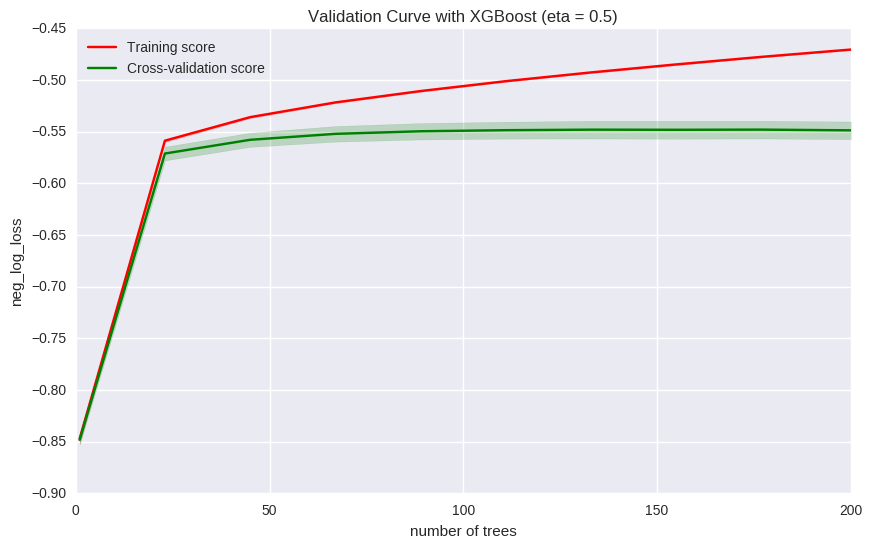

Best cross-validation result (-0.55) obtained for 177 trees


In [44]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.5)")
plt.xlabel("number of trees")
plt.ylabel("neg_log_loss")

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

#### Dealing with high variance
If model is too complex try:
- using less features (ie. feature selection),
- using more training samples (ie. artificially generated),
- increasing regularization (add penalties for extra complexity)

In XGBoost you can try to:
- reduce depth of each tree (`max_depth`),
- increase `min_child_weight` parameter,
- increase `gamma` parameter,
- add more randomness using `subsample`, `colsample_bytree` parameters,
- increase `lambda` and `alpha` regularization parameters

#### Dealing with high bias
If model is too simple:
- add more features (ie. better feature engineering),
- more sophisticated model
- decrease regularization

In XGBoost you can do it by:
- increase depth of each tree (`max_depth`),
- decrease `min_child_weight` parameter,
- decrease `gamma` parameter,
- decrease `lambda` and `alpha` regularization parameters

https://xgboost.readthedocs.io/en/latest/parameter.html

https://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html

Maybe helpful but not checked yet

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

`min_child_weight` 

### Hyper-parameter tuning

#### Grid-Search

In [28]:
from sklearn.model_selection import GridSearchCV

In [24]:
params_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [5, 10, 25, 50],
    'learning_rate': np.linspace(1e-16, 1, 3)
}

In [25]:
params_fixed = {
    'objective': 'multi:softprob',
    'silent': 1
}

In [31]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2017)

bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed),
    param_grid=params_grid,
    cv=skf,
    scoring='neg_log_loss'
)

In [32]:
bst_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2017, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 25, 50], 'learning_rate': array([  1.00000e-16,   5.00000e-01,   1.00000e+00]), 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [38]:
bst_grid.best_params_

{'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 50}

In [37]:
bst_grid.best_score_

-0.55369701243578895

#### Randomize Grid-Search

In [31]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [85]:
params_dist_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'gamma': [0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.]
}

In [86]:
params_fixed = {
    'objective': 'multi:softprob',
    'subsample': 0.7,
    'silent': 1
}

In [87]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2017)

rs_grid = RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=skf,
    scoring='neg_log_loss'
)

In [88]:
rs_grid.fit(X, y)

KeyboardInterrupt: 

In [39]:
rs_grid.best_params_

{'colsample_bytree': 0.3148797781637962,
 'gamma': 1,
 'learning_rate': 0.12970797503948339,
 'max_depth': 2,
 'n_estimators': 666,
 'subsample': 0.61471163233607695}

In [40]:
rs_grid.best_score_

-0.55063645940816919

### Evaluate results

### Deal with missing values

### Handle imbalanced Datasets

#### General advices<a name='generaladvices' />
These are some common tactics when approaching imbalanced datasets:

- collect more data,
- use better evaluation metric (that notices mistakes - ie. AUC, F1, Kappa, ...),
- try oversampling minority class or undersampling majority class,
- generate artificial samples of minority class (ie. SMOTE algorithm)

In XGBoost you can try to:
- make sure that parameter `min_child_weight` is small (because leaf nodes can have smaller size groups), it is set to `min_child_weight=1` by default,
- assign more weights to specific samples while initalizing `DMatrix`,
- control the balance of positive and negative weights  using `set_pos_weight` parameter,
- use AUC for evaluation

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [46]:
np.unique(y_train, return_counts=True)

(array([ 0.,  1.,  2.]), array([22970,  7523,  2572]))

In [50]:
params = {
    'max_depth': 2,
    'gamma': 1,
    'n_estimators': 500,
    'learning_rate': 0.2,
    'subsample': 0.6,
    'colsample_bytree': 0.3
}

In [52]:
bst = XGBClassifier(**params).fit(X_train, y_train)
y_test_preds = bst.predict(X_test)

In [55]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,2.0,All
Actual,,,,
0.0,10432,829,53,11314
1.0,2018,1500,188,3706
2.0,295,626,346,1267
All,12745,2955,587,16287


In [59]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds, average='macro')))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds, average='macro')))

Accuracy: 0.75
Precision: 0.64
Recall: 0.53


How to use `scale_pos_weight` for multi class classification?? -> it is for `binary classification`
https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost/18823

by using sample_weight, we can specify weight.
http://stackoverflow.com/questions/42192227/xgboost-python-classifier-class-weight-option

In [70]:
sample_weights = np.unique(y_train, return_counts=True)[1] * 1.0 / y_train.shape[0] * 1.0

In [71]:
sample_weights

array([ 0.69469227,  0.22752155,  0.07778618])

In [72]:
bst = XGBClassifier(**params).fit(X_train, y_train, sample_weight=sample_weights)
y_test_preds = bst.predict(X_test)

In [73]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0.0,All
Actual,,
0.0,11314,11314
1.0,3706,3706
2.0,1267,1267
All,16287,16287


In [74]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds, average='macro')))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds, average='macro')))

Accuracy: 0.69
Precision: 0.23
Recall: 0.33


dont know how to apply sample_weights,,

Maybe able to use xgboost with GPU
https://github.com/dmlc/xgboost/blob/master/plugin/updater_gpu/README.md